# Manipulating and visualizing spatial data with `geopandas`

- Today we're going to dive into looking at spatial data and visualizing it
- Spatial data is unique in that it can come in a different data form, it has to encode both information on the spatial features as well its location
- `geopandas` is an easy way to create maps and manipulate spatial data, especially if it's in the form of a shapefile
- For satellite data, there are other tools such as `xarray` and `that can be useful as it stores information as 3-D array
- Geospatial data is also unique in that it requires to think about how to flatten the 3-D world into a 2-D space
    - Coordinate Reference Systems (CRS)
    - When using geospatial data, you always need to specify a CRS as it will tell `geopandas` how to interpret the points and shapes as geographic information.

## Installing `geopandas`

- We might have been using `pip` until this point, but for `geopandas` we need to use `conda` as there are non-python software that needs to be installed for it to work:

```
conda install -c conda-forge geopandas
```

- But this might take a while...

## CRS

![](images/0637aa2541b31f526ad44f7cb2db7b6c.jpg)

- CRS can be broken down into two main components:
    - **Datum**: a model of the shape of the earth, specifying where the origin of a ellipsoidal/spheroid/other approximation 
    - This is a lot of fancy talk, but we can illustrate this well in pictures:
        - Reference for figures: https://csegrecorder.com/articles/view/datums-projections-and-coordinate-systems
    ![](images/2017-03-datums-projections-fig03.jpg)
    ![](images/2017-03-datums-projections-fig04.jpg)

    - **Projection**: Transformation from angular measurements of the earth to linear units like feet, miles, kilometers...
        - Since the earth is an oblate sphere, the projection from 3-D to 2-D will create distortions
        - There is a tradeoff between preserving the shape and angles of the earth and those that preserve areas 
        - This is important to note if you need to calculate distances for particular parts of a map
        - If you need to calculate areas of shapes or distances, you need to choose the correct projection


In [16]:
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
import warnings
from ipywidgets import interact
import shapely
import geopandas as gpd
import pandas as pd
import ee
import geemap
import folium
# warnings.filterwarnings('ignore')

In [2]:
projections = {
    'orthographic' : (ccrs.Orthographic(), "The globe"),
    'mercator' : (ccrs.Mercator(), 'shapes and angles are preserved, but areas are distorted'),
    'robinson' : (ccrs.Robinson(), 'Neither are preserved, but looks nice'),
    'albers' : (ccrs.AlbersEqualArea(), 'areas are little-distorted, but shapes are not preserved'),
    'utm' : (ccrs.UTM(18), 'Universal Transverse Mercator projection. A small zone with little distortion of area and shape.'),
    'utm_all' : (None, 'All UTMs')
}

@interact(projection = projections.keys())
def interactive_tissot(projection):
    fig = plt.figure(figsize=(10, 5))
    projection_type, message = projections.get(projection)
    if projection == 'utm_all':
        nplots = 60

        fig = plt.figure(figsize=(10, 3))

        for i in range(0, nplots):
            ax = fig.add_subplot(1, nplots, i+1,
                                projection=ccrs.UTM(zone=i+1,
                                                    southern_hemisphere=True))
            ax.coastlines(resolution='110m')
            ax.gridlines()
            ax.tissot(facecolor='orange', alpha=0.4)
    else:
        ax = fig.add_subplot(1, 1, 1, projection=projection_type)

        # make the map global rather than have it zoom in to
        # the extents of any plotted data
        ax.set_global()

        ax.coastlines(resolution='110m')
        ax.coastlines()

        ax.tissot(facecolor='orange', alpha=0.4)


interactive(children=(Dropdown(description='projection', options=('orthographic', 'mercator', 'robinson', 'alb…

- For spatial data, you can summarize the information in a PROJ4 string
- This is a standard way of signifying the CRS information:

```
+proj=utm +zone=18 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0
```

```
proj=: the projection of the data
zone=: the zone of the data (this is specific to the UTM projection)
datum=: the datum use
units=: the units for the coordinates of the data
ellps=: the ellipsoid (how the earth’s roundness is calculated) for the data
```

## EPSG and using projections in practice

- In practice, most time we will use the EPSG system, which gives an easy way to choose a CRS and switch between them.
- The EPSG system is a database of CRS information maintained by the International Association of Oil and Gas Producers. 
    - The dataset contains both CRS definitions and information on how to safely convert data from one CRS to another. Using EPSG is easy as every CRS has a integer identifier, e.g. WGS84 is EPSG:4326. 
    - The downside is that you can only use the CRSs EPSG defines and cannot customise them. 
    - Source: https://datacarpentry.org/organization-geospatial/03-crs.html

## Loading Data for `geopandas`

- `geopandas` is good for loading and using shapefiles, KMZ files or GeoJSON files
- In most ways, using `geopandas` is just like using `pandas`. 
- The same operations and syntax
- But `geopandas` has two added features: the CRS and an important `geometry` columns that holds spatial information
- `geopandas` uses the `shapely` library to create shapes, points, and to do spatial operations


## Quickly with Shapely

- Shapely is a library designed for creating shapes, and for doing spatial operations, like joins, union, intersections and the like
- There are various types of shapely polygons:
    - Points
    - LineStrings
    - Polygons
    - MultiLineStrings
    - MultiPolygons

In [3]:
point = shapely.Point([0,0])

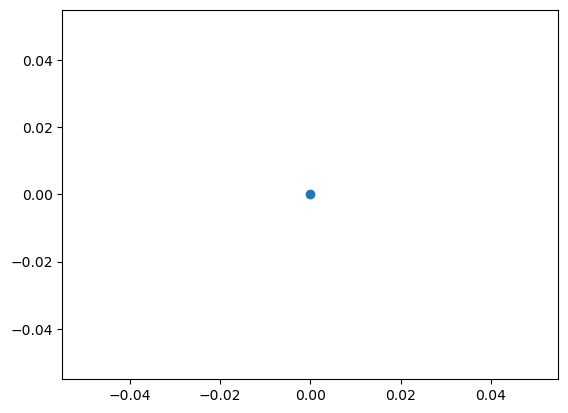

In [4]:
plt.scatter(point.x, point.y, marker='o', )

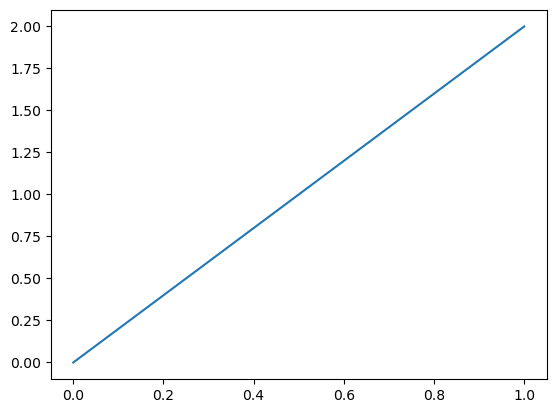

In [5]:
line = shapely.LineString([[0,0], [1,2]])

x,y = [(l[0], l[1]) for l in line.xy]

plt.plot(x,y)


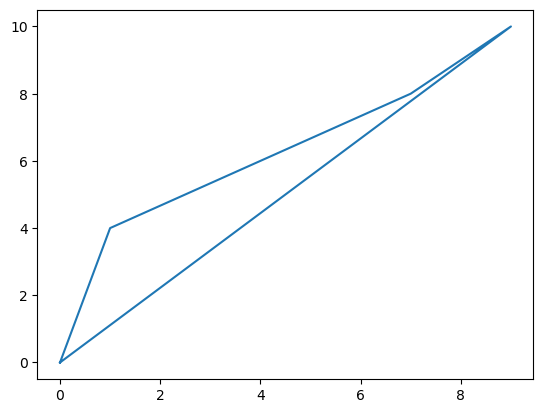

In [6]:
shape = shapely.Polygon(
    [[0,0], [1,4], [4,6], [7,8], [9,10]]
)

x,y = shape.exterior.xy

plt.plot(x,y)

## Loading into Geopandas

-  You can find shapefiles all over the internet, just google "{country} shapefile"
- Let's use one for the US

In [7]:
us = gpd.read_file("data/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")

In [8]:
us

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05351 41.15726, -104.05267 41.2..."
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-122.32834 48.02134, -122.3217..."
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.05017 31.48000, -109.04984 31.4..."
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.05770 44.99743, -104.05021 44.9..."
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.64548 31.89867, -106.64084 31.9..."
5,06,01779778,0400000US06,06,CA,California,00,403503931312,20463871877,"MULTIPOLYGON (((-118.60337 33.47810, -118.5987..."
6,21,01779786,0400000US21,21,KY,Kentucky,00,102279490672,2375337755,"MULTIPOLYGON (((-89.40565 36.52817, -89.39869 ..."
7,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.73571 41.60336, -82.71880 ..."
8,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.04374 30.51742, -88.03661 ..."
9,13,01705317,0400000US13,13,GA,Georgia,00,149482048342,4422936154,"POLYGON ((-85.60516 34.98468, -85.55259 34.984..."


In [9]:
us.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [10]:
us.crs.to_proj4()

/Users/lordflaron/opt/anaconda3/envs/zipline-env/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


'+proj=longlat +datum=NAD83 +no_defs +type=crs'

- The geometry encodes the information in the spatial data
- There are some important operations to know:
    - area
    - centroid

In [11]:
us.geometry.centroid

/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_69453/3838066817.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us.geometry.centroid


0       POINT (-99.81085 41.52715)
1      POINT (-120.45086 47.38228)
2      POINT (-106.10838 34.42136)
3      POINT (-100.23045 44.43613)
4       POINT (-99.34940 31.48260)
5      POINT (-119.61056 37.24596)
6       POINT (-85.29057 37.52666)
7       POINT (-82.79018 40.29356)
8       POINT (-86.82877 32.78882)
9       POINT (-83.44597 32.64909)
10      POINT (-90.01148 44.63949)
11     POINT (-120.55517 43.93666)
12      POINT (-77.79960 40.87389)
13      POINT (-89.66428 32.74882)
14      POINT (-92.47742 38.36766)
15      POINT (-79.35641 35.53969)
16      POINT (-97.50844 35.58355)
17      POINT (-80.61384 38.64253)
18      POINT (-75.50262 42.94018)
19      POINT (-86.27563 39.90814)
20      POINT (-98.38022 38.48470)
21     POINT (-114.65936 44.38909)
22     POINT (-116.65539 39.35643)
23      POINT (-72.66272 44.07520)
24     POINT (-109.64512 47.03349)
25      POINT (-94.30876 46.31660)
26     POINT (-100.46931 47.44630)
27     POINT (-156.35293 20.25312)
28     POINT (-111.6

In [12]:
us.geometry.area

/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_69453/3347392874.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us.geometry.area


0      21.614224
1      20.935560
2      30.892952
3      22.578589
4      65.362487
5      41.667457
6      10.668499
7      11.339602
8      12.897722
9      14.669411
10     16.502663
11     28.176727
12     12.535036
13     11.893959
14     18.615689
15     12.850827
16     18.004400
17      6.493658
18     14.029214
19      9.873087
20     22.004265
21     24.456791
22     29.937645
23      2.797733
24     45.077200
25     25.541058
26     21.839321
27      1.445760
28     28.921795
29      0.545919
30      0.308932
31     28.039251
32     22.974876
33     10.701644
34     27.972103
35     11.617687
36     17.081060
37      2.325932
38     13.993004
39      0.039166
40      1.396944
41      2.132001
42      2.803139
43      7.858471
44      9.847687
45      2.683803
46      0.018377
47      0.048671
48      0.045893
49      0.020597
50     15.856894
51      0.773416
52     13.584227
53     10.889701
54     15.407859
55    282.986562
dtype: float64

- Notice that we got a warning
- `geopandas` tells us that we are in a "geographic CRS"
- This means that we are in a CRS that spans the globe and might be good for plotting, but it isn't good for estimating distance or area
- Let's choose one state and try to figure out the UTM CRS for Colorado

In [13]:
us

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05351 41.15726, -104.05267 41.2..."
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-122.32834 48.02134, -122.3217..."
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.05017 31.48000, -109.04984 31.4..."
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.05770 44.99743, -104.05021 44.9..."
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.64548 31.89867, -106.64084 31.9..."
5,06,01779778,0400000US06,06,CA,California,00,403503931312,20463871877,"MULTIPOLYGON (((-118.60337 33.47810, -118.5987..."
6,21,01779786,0400000US21,21,KY,Kentucky,00,102279490672,2375337755,"MULTIPOLYGON (((-89.40565 36.52817, -89.39869 ..."
7,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.73571 41.60336, -82.71880 ..."
8,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.04374 30.51742, -88.03661 ..."
9,13,01705317,0400000US13,13,GA,Georgia,00,149482048342,4422936154,"POLYGON ((-85.60516 34.98468, -85.55259 34.984..."


In [14]:
colorado = us.query("NAME == 'Colorado'")


colorado_crs = colorado.estimate_utm_crs()

print(colorado_crs.is_projected)

epsg_code = colorado_crs.to_epsg()

colorado = colorado.to_crs(f"epsg:{epsg_code}")
colorado.area

colorado.centroid

# No more warning!


True


31    POINT (452490.749 4316656.166)
dtype: geometry

- However, look: our US CRS and Colorado CRS are different!


(-170.0, -50.0)

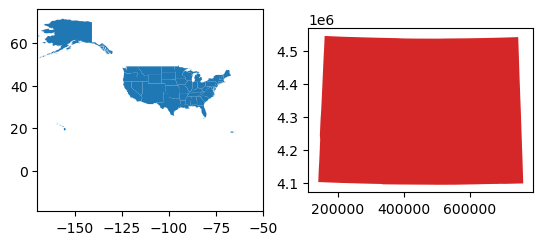

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2)

us.plot(ax = ax1)
colorado.plot(ax=ax2, color='tab:red')

ax1.set_xlim([-170,-50])

- If we try to plot Colorado and the US together now, it won't show...
- we have to reproject the CRS back to the on in the US

(-170.0, -50.0)

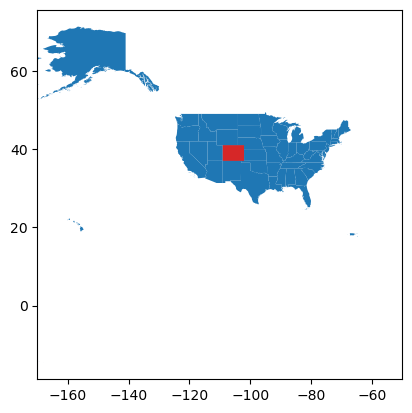

In [16]:
fig, ax1 = plt.subplots()

us.plot(ax = ax1)
colorado.to_crs('epsg:4326').plot(ax=ax1, color='tab:red')

ax1.set_xlim([-170,-50])

## Generating a Chloropleth

- Now that we have the basics down, let's visualize some data on a map.
- This is pretty easy and is on step
- Let's first get some GDP numbers from the internet
    - pandas `read_html` will look for tables from a url and load it
    - Thankfully there's a table on wikipedia!

In [17]:
gdp = pd.read_html("https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_GDP")[0].iloc[1:]


In [18]:
gdp

State or federal district  \
   State or federal district   
1               California *   
2                    Texas *   
3                 New York *   
4                  Florida *   
5                 Illinois *   
6             Pennsylvania *   
7                     Ohio *   
8                  Georgia *   
9               New Jersey *   
10          North Carolina *   
11              Washington *   
12           Massachusetts *   
13                Virginia *   
14                Michigan *   
15                Colorado *   
16               Tennessee *   
17                Maryland *   
18                 Arizona *   
19                 Indiana *   
20               Minnesota *   
21               Wisconsin *   
22                Missouri *   
23             Connecticut *   
24                  Oregon *   
25          South Carolina *   
26               Louisiana *   
27                 Alabama *   
28                Kentucky *   
29                    Utah *   
30                Oklahoma *   
31                    Iowa *   
32                  Nevada *   
33                  Kansas *   
34                Arkansas *   
35                Nebraska *   
36     District of Columbia*   
37             Mississippi *   
38              New Mexico *   
39                   Idaho *   
40           New Hampshire *   
41                  Hawaii *   
42           West Virginia *   
43                Delaware *   
44                   Maine *   
45            North Dakota *   
46            Rhode Island *   
47            South Dakota *   
48                 Montana *   
49                  Alaska *   
50                 Wyoming *   
51                 Vermont *   
52           United States *   

   Nominal GDP at current prices 2022 (millions of U.S. dollars)[1]  \
                                                               2022   
1                                           3598103.0                 
2                                           2355960.0                 
3                                           2053180.0                 
4                                           1389070.0                 
5                                           1033310.0                 
6                                            923089.0                 
7                                            822670.0                 
8                                            755698.0                 
9                                            745422.0                 
10                                           730072.0                 
11                                           725514.0                 
12                                           688392.0                 
13                                           649393.0                 
14                                           620696.0                 
15                                           484372.0                 
16                                           475755.0                 
17                                           470187.0                 
18                                           458950.0                 
19                                           455750.0                 
20                                           446500.0                 
21                                           401792.0                 
22                                           389931.0                 
23                                           321845.0                 
24                                           299125.0                 
25                                           295880.0                 
26                                           281429.0                 
27                                           277817.0                 
28                                           260304.0                 
29                                           248176.0                 
30                                           240534.0                 
31

In [19]:
# get only the state name and GDP growth rate for 2021-2022
gdp_processed = (
    gdp[['State or federal district', 'Real\xa0GDP\xa0growth rate\xa0(2021–2022)[1]']]
    .droplevel(0, axis=1)
    .rename({'Real\xa0GDP\xa0growth rate\xa0(2021–2022)[1]': 'gdp_growth',
            'State or federal district': 'state'}, axis=1)
    .assign(state= lambda df: df['state'].str.replace("*", '').str.strip(),
            gdp_growth = lambda df: df['gdp_growth'].str.replace("%", '').astype(float))
    .query("state != 'United States'")
    )

# # be careful about strings
# gdp_processed.state.iloc[0]


/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_69453/3441359414.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .assign(state= lambda df: df['state'].str.replace("*", '').str.strip(),


In [20]:
gdp_processed.to_csv("gdp_processed.csv")

- Remember: if you merge a pandas with a geopandas, you get a pandas.
- To preserve the geopandas frame, merge geopandas with pandas

(20.0, 55.0)

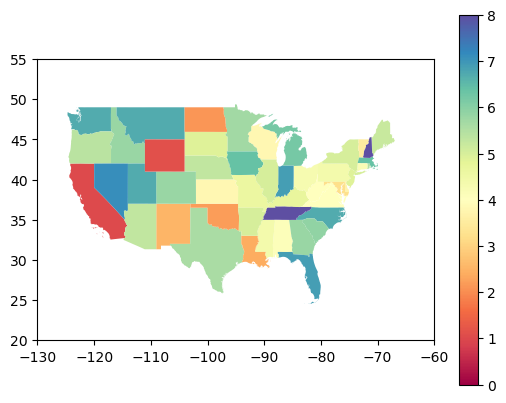

In [21]:
fig, ax = plt.subplots()

(us
 .merge(gdp_processed, left_on='NAME', right_on = 'state')
 .plot('gdp_growth', ax=ax, cmap='Spectral',
        legend=True, vmin=0, vmax=8)
 )

ax.set_xlim([-130, -60])
ax.set_ylim([20, 55])

# since the figure is matplotlib, you can use the same matplotlib commands as before


## Interactive maps

- `geopandas` also has another way to plot data and make things interactive
- Instead of using `plot`, we can use `explore`
- the syntax is a little different because `explore` uses a library called `folium`

In [22]:
# rather than using `ax` with matplotlib, `explore` returns a folium map object that you can call

m = (us
 .merge(gdp_processed, left_on='NAME', right_on = 'state')
 .explore('gdp_growth', cmap='Blues',
        legend=True, vmin=0, vmax=8,
        tooltip=['gdp_growth'])
 )

us.query("NAME == 'Colorado'").explore(m=m, color='red')


## Loading Raster Data

- We've been looking at vector files up until now
- They store location and shapes
- Now we'll look at rasters
    - A raster is a grid of cells where each cell encodes different information
    - We need a different library to load such data
    - A ubiquitous file format for raster are TIFFs or GeoTIFFS

![](images/mod1-rastervector1.png)

x

## Using Google Earth Engine

- A large part of doing economics today might involve using satellite data
- Satellite data is expansive and remote sensing is very important in doing research.
- Satellites orbit the earth and capture snapshots:
    - the surface
    - elevation
    - Radar 
    - as well as different color "bands" that can be used for capturing different phenomena
    - Satellite datasets are often large and there are ways to take advantage of services that makes things easier for processing
- For this class, we are going to do a very basic thing in google earth engine: calculate and visualize ndvi


In [14]:
ee.Authenticate()


Successfully saved authorization token.


In [17]:
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001")
      .get("title")
      .getInfo()
      )


NASADEM: NASA NASADEM Digital Elevation 30m


- We will be using Landsat satellite 
- Other satellites have NDVI, like the MODIS satellite, but we'll construct it from scratch now.
- Google Earth Engine has its own syntax, which we can delve more deeply into in special topic.
- Just know that since this is all going through Google Earth Engine which is used in `javascript`, we need to have a way to make the conversion
- `ee` gives us those tools
- Google Earth Engine has a lot of great stuff and you can look for datasets here: https://developers.google.com/earth-engine/datasets/
- You can also create interactive maps or save them to your computer for papers


In [8]:
today = ee.Date(pd.to_datetime('today'))
today
date_range = ee.DateRange(today.advance(-20, 'years'), today) # take it from 20 years ago
date_range
# # you can get 
landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA').filterDate(date_range)

landsat


/Users/lordflaron/opt/anaconda3/lib/python3.9/site-packages/eerepr/repr.py:57: UserWarning: Getting info failed with: 'Collection query aborted after accumulating over 5000 elements.'. Falling back to string repr.
  warn(f"Getting info failed with: '{e}'. Falling back to string repr.")


In [18]:
landsat
# this doesn't output anything. To ge a set of variables, you need to search it on GEE
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_TOA

- Landsat is a popular satellite that is used for constructing vegetation indices
- There are various Landsats that have imagery from different times and at varying levels of detail

![](images/Landsat-timeline-LNext-2023_4297.png)

- Landsat orbits the earth in a sun-synchronous orbit and gets a whole image of the earth in 16 days
- So these image collections hold data across time and are not daily data.
- To get particular piece of land on the satellite, GEE will "mosaic" them together from different times to get a particular piece of land

![](images/download.png)

- Let's extract the bands we need for NDVI from the image collection

In [19]:
point = ee.Geometry.Point([-122.292, 37.9018])

image = ee.Image(
  landsat.filterBounds(point)
    .filterDate('2015-01-01', '2015-12-31')
    .sort('CLOUD_COVER')
    .first()
)

nir = image.select('B5')
red = image.select('B4')
ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')


In [20]:
ndvi

In [22]:

lat, lon = 37.9018, -122.292, 

vis_params = {
    'min': -1,'max': 1,
    'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
}

Map = geemap.Map(center=(lat, lon), zoom=4)
Map.addLayer(ndvi, vis_params, 'SRTM DEM', True, 0.5)

Map

Map(center=[37.9018, -122.292], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

### Night-time Lights

- Now we will load and look at night-time lights data from the World Bank
- Also in GEE
- Night-time lights are great for measuring economic productivity
    - gas flares
    - agricultural fires
    - fishing boats
    - electricity use

In [23]:
dmsp1996 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F101992")

dmsp1996


In [24]:
aoi = ee.Geometry.Polygon(
    [[[-110.8, 44.7], [-110.8, 44.6], [-110.6, 44.6], [-110.6, 44.7]]], None, False
)

raster = geemap.ee_to_numpy(dmsp1996, region = aoi)

In [25]:
raster.shape

(13, 25, 4)

In [26]:
center_lat = 38.9072
center_lon = -77.0369
zoomlevel=10

# initialize our map
map1 = geemap.Map(center=[center_lat,center_lon], zoom=zoomlevel)
map1.add_basemap('SATELLITE')

map1.addLayerControl()

map1.addLayer(dmsp1996, {}, "DMSP-OLS 1996", opacity=0.75)

map1


Map(center=[38.9072, -77.0369], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

In [28]:
dmsp2010 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F182010")

# initialize our map
map2 = geemap.Map(center=[center_lat,center_lon], zoom=zoomlevel)
map2.add_basemap('SATELLITE')

# generate tile layers
dmsp1996_tile = geemap.ee_tile_layer(dmsp1996.mask(dmsp1996), {}, 'DMSP-OLS 1996', opacity=1)
dmsp2010_tile = geemap.ee_tile_layer(dmsp2010.mask(dmsp2010), {}, 'DMSP-OLS 2010', opacity=1)

# create split map
map2.split_map(left_layer=dmsp1996_tile, right_layer=dmsp2010_tile)
map2

Map(center=[38.9072, -77.0369], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

## Recap

- Today we learned how to use `geopandas`, `ee`, and `geemap` to visualize spatial data
- One note that we didn't get to: we can use the vector information we had to do overlays in `geemap`
- https://geemap.org/tutorials/
